In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
filepath_dict = {
    'yelp': './Dataset/yelp_labelled.txt',
    'imdb': './Dataset/imdb_labelled.txt',
    'amzn': './Dataset/amazon_cells_labelled.txt'
}

In [4]:
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

In [5]:
df = pd.concat(df_list)
del df_list

In [6]:
df.shape

(2748, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 999
Data columns (total 3 columns):
sentence    2748 non-null object
label       2748 non-null int64
source      2748 non-null object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


### feature-engineering

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
import string
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
for i in string.punctuation:
    english_stop_words.append(i)

In [44]:
sentences = df['sentence'].values
y = df['label'].values
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=42)
vectorizer = CountVectorizer(stop_words=english_stop_words)
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

## Modelling

In [22]:
from keras.models import Sequential
from keras.layers import Dense

In [19]:
input_dim = X_train.shape[1]
model = Sequential()
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                42490     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train, epochs=50, verbose=True, validation_data=(X_test, y_test), batch_size=100)

Instructions for updating:
Use tf.cast instead.
Train on 2061 samples, validate on 687 samples
Epoch 1/50
2061/2061 [==============================] - 1s 280us/step - loss: 0.6909 - acc: 0.5517 - val_loss: 0.6873 - val_acc: 0.5968
Epoch 2/50
2061/2061 [==============================] - 0s 52us/step - loss: 0.6727 - acc: 0.7603 - val_loss: 0.6770 - val_acc: 0.6681
Epoch 3/50
2061/2061 [==============================] - 0s 54us/step - loss: 0.6471 - acc: 0.8530 - val_loss: 0.6600 - val_acc: 0.7394
Epoch 4/50
2061/2061 [==============================] - 0s 54us/step - loss: 0.6116 - acc: 0.8976 - val_loss: 0.6396 - val_acc: 0.7656
Epoch 5/50
2061/2061 [==============================] - 0s 56us/step - loss: 0.5703 - acc: 0.9127 - val_loss: 0.6174 - val_acc: 0.7787
Epoch 6/50
2061/2061 [==============================] - 0s 62us/step - loss: 0.5273 - acc: 0.9277 - val_loss: 0.5950 - val_acc: 0.7846
Epoch 7/50
2061/2061 [==============================] - 0s 69us/step - loss: 0.4838 - acc: 0.9

In [26]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print('Training Accuracy: {:.4f}, Loss: {:.4f}'.format(accuracy, loss))
loss,accuracy = model.evaluate(X_test, y_test, verbose=False)
print('Testing Accuracy: {:.4f}, Loss: {:.4f}'.format(accuracy, loss))

Training Accuracy: 0.9884, Loss: 0.0541
Testing Accuracy: 0.7860, Loss: 0.4866


In [27]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

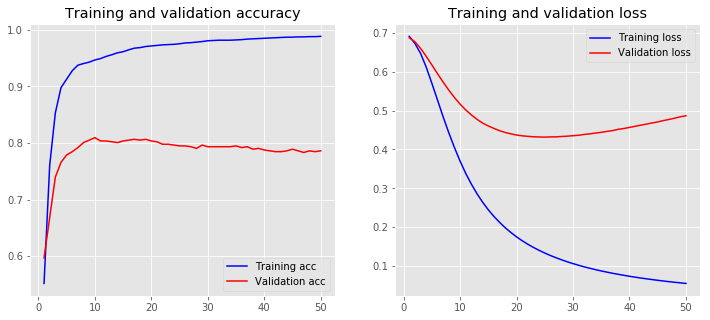

In [28]:
plot_history(history)

### Using word-embedding

In [60]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Flatten, GlobalMaxPool1D

In [46]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index)+1

#### pad sequences with keras

In [47]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test  = pad_sequences(X_test,  padding='post', maxlen=maxlen)

In [50]:
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=maxlen))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [51]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           224000    
Total params: 224,000
Trainable params: 224,000
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    verbose=True, 
                    validation_data=(X_test, y_test), 
                    batch_size=100)

Train on 2061 samples, validate on 687 samples
Epoch 1/50
2061/2061 [==============================] - 1s 269us/step - loss: 0.6946 - acc: 0.5002 - val_loss: 0.6923 - val_acc: 0.5240
Epoch 2/50
2061/2061 [==============================] - 0s 70us/step - loss: 0.6914 - acc: 0.5706 - val_loss: 0.6920 - val_acc: 0.5226
Epoch 3/50
2061/2061 [==============================] - 0s 70us/step - loss: 0.6881 - acc: 0.5978 - val_loss: 0.6903 - val_acc: 0.5240
Epoch 4/50
2061/2061 [==============================] - 0s 72us/step - loss: 0.6813 - acc: 0.6618 - val_loss: 0.6870 - val_acc: 0.5852
Epoch 5/50
2061/2061 [==============================] - 0s 72us/step - loss: 0.6540 - acc: 0.7045 - val_loss: 0.6652 - val_acc: 0.6681
Epoch 6/50
2061/2061 [==============================] - 0s 91us/step - loss: 0.5420 - acc: 0.9015 - val_loss: 0.6111 - val_acc: 0.6885
Epoch 7/50
2061/2061 [==============================] - 0s 72us/step - loss: 0.3579 - acc: 0.9520 - val_loss: 0.5216 - val_acc: 0.7918
Epoch 8

In [55]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print('Training Accuracy: {:.4f}, Loss: {:.4f}'.format(accuracy, loss))
loss,accuracy = model.evaluate(X_test, y_test, verbose=False)
print('Testing Accuracy: {:.4f}, Loss: {:.4f}'.format(accuracy, loss))

Training Accuracy: 1.0000, Loss: 0.0005
Testing Accuracy: 0.7831, Loss: 0.7091


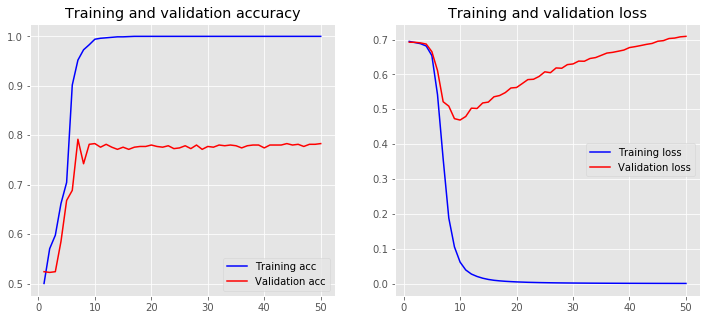

In [56]:
plot_history(history)

#### Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model

In [62]:
embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [63]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           224000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 224,521
Trainable params: 224,521
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=100)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 2061 samples, validate on 687 samples
Epoch 1/50
2061/2061 [==============================] - 1s 313us/step - loss: 0.6910 - acc: 0.6012 - val_loss: 0.6883 - val_acc: 0.6608
Epoch 2/50
2061/2061 [==============================] - 0s 79us/step - loss: 0.6784 - acc: 0.7569 - val_loss: 0.6790 - val_acc: 0.7060
Epoch 3/50
2061/2061 [==============================] - 0s 76us/step - loss: 0.6583 - acc: 0.8879 - val_loss: 0.6622 - val_acc: 0.7802
Epoch 4/50
2061/2061 [==============================] - 0s 83us/step - loss: 0.6266 - acc: 0.9054 - val_loss: 0.6358 - val_acc: 0.7991
Epoch 5/50
2061/2061 [==============================] - 0s 85us/step - loss: 0.5739 - acc: 0.9161 - val_loss: 0.5916 - val_acc: 0.8035
Epoch 6/50
2061/2061 [==============================] - 0s 109us/step - loss: 0.5001 - acc: 0.9330 - val_loss: 0.5414 - val_acc: 0.8166
Epoch 7/50
2061/2061 [==============================] - 0s 87us

In [66]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8122


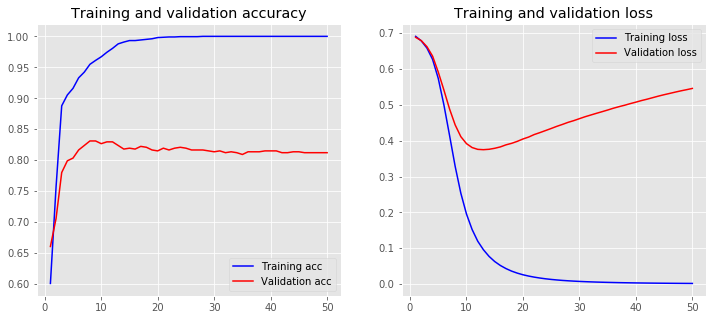

In [67]:
plot_history(history)

### Using CNN

In [70]:
from keras.layers import Conv1D

In [71]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [72]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          448000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 513,429
Trainable params: 513,429
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=100)

In [98]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7962


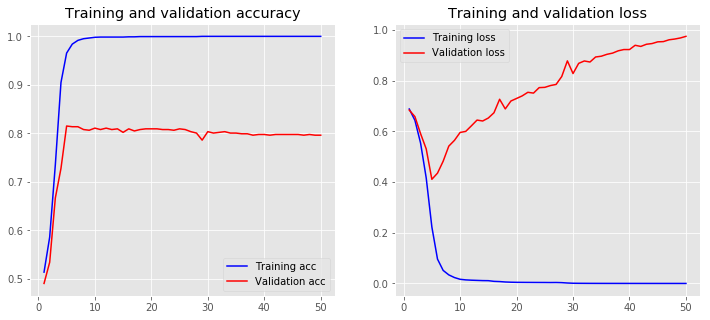

In [99]:
plot_history(history)

### Hyperperameters Optimization

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [119]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [113]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [120]:
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'output.txt'

for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    vocab_size = len(tokenizer.word_index) + 1

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=100,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    test_accuracy = grid.score(X_test, y_test)
    
    s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        source,
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)

Running grid search for data set : amzn
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.6min finished


Running amzn data set
Best Accuracy : 0.8098
{'num_filters': 64, 'vocab_size': 4376, 'kernel_size': 3, 'embedding_dim': 50, 'maxlen': 100}
Test Accuracy : 0.8268


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.6min finished


Running imdb data set
Best Accuracy : 0.8054
{'num_filters': 64, 'vocab_size': 4376, 'kernel_size': 5, 'embedding_dim': 50, 'maxlen': 100}
Test Accuracy : 0.8268


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.8min finished


Running yelp data set
Best Accuracy : 0.8151
{'num_filters': 64, 'vocab_size': 4376, 'kernel_size': 3, 'embedding_dim': 50, 'maxlen': 100}
Test Accuracy : 0.8384


